In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
# inspector.get_columns(Measurement)
columns = inspector.get_columns('measurement')

In [11]:
def ColumnInfo (table_name):
    '''Takes the name of a column and usus SQLAlchemy to print its column names and types. '''
    columns = inspector.get_columns(table_name)
    
    for c in columns:
        print(c['name'], c['type'])

In [12]:
# Print column info
ColumnInfo('measurement')
print('----------------')
ColumnInfo('station')

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# date 1 week ago from today
week_ago = dt.date.today() - dt.timedelta(days=7)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Find the latest date
lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Convert last date from str to datetime
lastDate = dt.datetime.strptime(lastDate, '%Y-%m-%d')
print(lastDate)

# Calculate the date 1 year ago from the last data point in the database
year_ago = lastDate - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
prcp_lastYear = session.query(Measurement.date, Measurement.prcp).\
                    filter(func.strftime('%Y-%m-%d', Measurement.date) >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_lastYear)
prcp_df.head()

2017-08-23 00:00:00
2016-08-23 00:00:00


,date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [15]:
# Sort the dataframe by date
prcp_sorted = prcp_df.sort_values(by=['date'], ascending=True)

# Rename Columns
prcp_sorted = prcp_sorted.rename(columns={'date':'date'.title(), 'prcp':'precipitation'.title()})
prcp_sorted.head()

,Date,Precipitation
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15


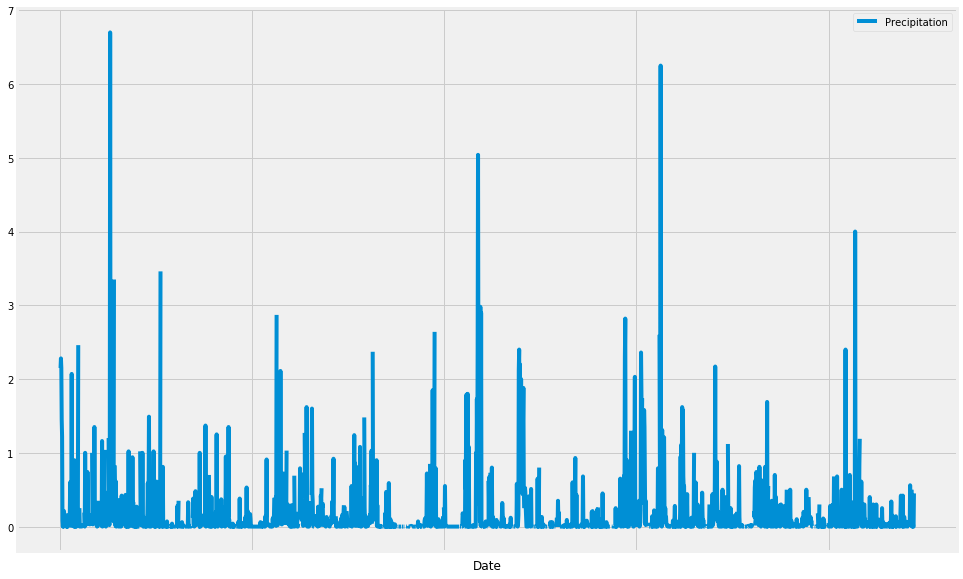

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

# Make graph pretty later
prcp_sorted.plot(x='Date',y= 'Precipitation', figsize=(15,10))

In [18]:
# Summary Statistics
prcp_sorted.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [20]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).scalar()
print(f'There are {station_count} stations in this dataset')

There are 9 stations in this dataset


In [21]:
session.query(Station.id, Station.name).all()

[(1, 'WAIKIKI 717.2, HI US'),
 (2, 'KANEOHE 838.1, HI US'),
 (3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (4, 'PEARL CITY, HI US'),
 (5, 'UPPER WAHIAWA 874.3, HI US'),
 (6, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (7, 'WAIHEE 837.5, HI US'),
 (8, 'HONOLULU OBSERVATORY 702.2, HI US'),
 (9, 'MANOA LYON ARBO 785.2, HI US')]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Query to get the station name of the statioon with the most entries
max_station = session.query(Measurement.station).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).first()[0]
                                                       
print(max_station)

USC00519281


In [25]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# Query for max temp for station with highest entries
max_temp = session.query(func.max(Measurement.tobs)).\
            filter(Measurement.station == max_station).all()

print(max_temp)

[(85.0,)]


In [26]:
# Query for min temp for the station with the most entries
min_temp = session.query(func.min(Measurement.tobs)).\
            filter(Measurement.station == max_station).all()

print(min_temp)

[(54.0,)]


In [27]:
# Query foor Average temp for the station with the most entries
avg_temp = session.query(func.avg(Measurement.tobs)).\
            filter(Measurement.station == max_station).all()

print(avg_temp)

[(71.66378066378067,)]


In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

lastYear_tobs = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == max_station).\
                    filter(func.strftime('%Y-%m-%d', Measurement.date) >= year_ago).all()

tobs_df = pd.DataFrame(lastYear_tobs)
tobs_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 52., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

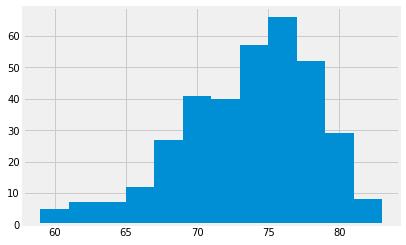

In [29]:
# Plot a histogram of tobs
plt.hist(x=tobs_df.tobs, bins=12)

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


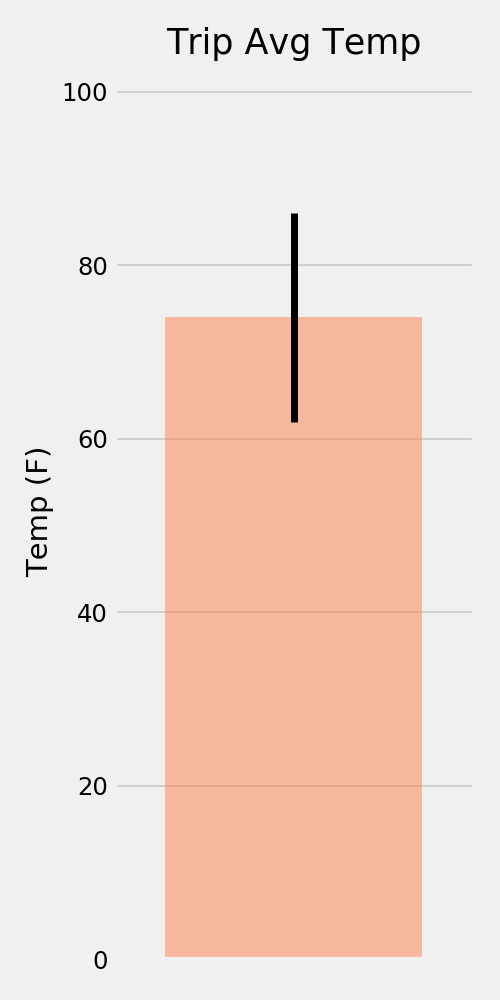

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


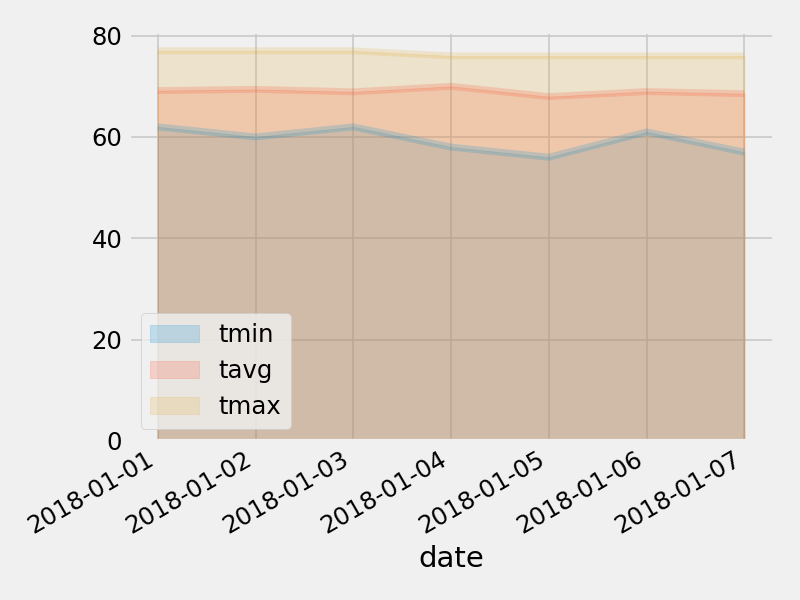

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
